# Housing price prediction : The big picture




Welcome to the Machine Learning Housing Corporation!  

Our task is to build a model using California census data to predict housing prices.  

The data includes details like population, median income, and housing prices for small areas called block groups (or "districts"), which usually have 600–3,000 people.  

Our model will use this data **to predict the median housing price** in a district based on other metrics.



## Framing the problem


### What is the business objective is?



The goal isn’t just to build a model but to understand how the company plans to use it and benefit from it.  


Knowing the objective helps **define the problem**, **choose algorithms**, **select a performance measure**, and **decide how much effort to spend improving the model**.  


In our current project, our model’s predictions (median housing prices) will be used by another system, alongside other data, to decide if investing in an area is worthwhile. <br>

**This decision is crucial as it impacts revenue.**


### What is the current solution (if it exists) ?


Understanding it can provide a **performance baseline** and **ideas for solving the problem**.  

In our corporation, housing prices are **<span style="font-family:Comic Sans MS; color:red">currently estimated manually</span>** by experts who gather district data and use complex rules when the median price isn’t available. This process is **<span style="font-family:Comic Sans MS; color:red">expensive</span>**, **<span style="font-family:Comic Sans MS; color:red">slow</span>**, and **<span style="font-family:Comic Sans MS; color:red">often inaccurate—estimates</span> are <span style="font-family:Comic Sans MS; color:red"> frequently off by over 30%</span>**.  


The company wants <ins>to train a model to predict median housing prices using district data</ins>. <br>

Census data, which includes prices and other district information for thousands of areas, is ideal for this task.   


### What is the type of learning ?



With the gathered information, we are ready to design our system.


- This is a **supervised learning task** because the model can train on labeled examples (districts with their median housing prices).  

- It’s a **regression task** since the goal is to predict a value. Specifically, it’s a **multiple regression** problem because the prediction uses several features (like population and median income).  

- It’s **univariate regression** because only one value (median price) is predicted for each district. If multiple values were predicted, it would be multivariate regression.  
- Since the data is not continuously flowing, doesn’t require rapid updates, and fits in memory, **batch learning** is sufficient.

## Selecting a performance measure


The next step is to choose a performance measure. <br>

For regression problems, a common choice is the **root mean square error (RMSE)**.<br> 

It shows how much error the model typically makes, giving more weight to larger errors. 


 $$RMSE  = \sqrt{\frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2 }$$
 

# Getting the data


## Import libraries


Here will be imported all the necessary libraries that we'll use for this task !



In [80]:
# Libraries to import data
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

# Visualization
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

# Split train set and test set
from sklearn.model_selection import train_test_split

# General libraries
import numpy as np
from scipy.stats import iqr
from scipy.stats import randint
from scipy import stats

# Preprocessing the data
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler

# Pipelines
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error

# Saving/loading models
import joblib

## Import the data


We import the data and store it locally.


In [2]:
# Retrieve the data
def load_housing_data():
    tarball_path = Path("../data/raw_data/datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("../data/raw_data/datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Exploring the data


## Quick exploration


In [3]:
# summary of the DataFrame
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# Descriptive statistics
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


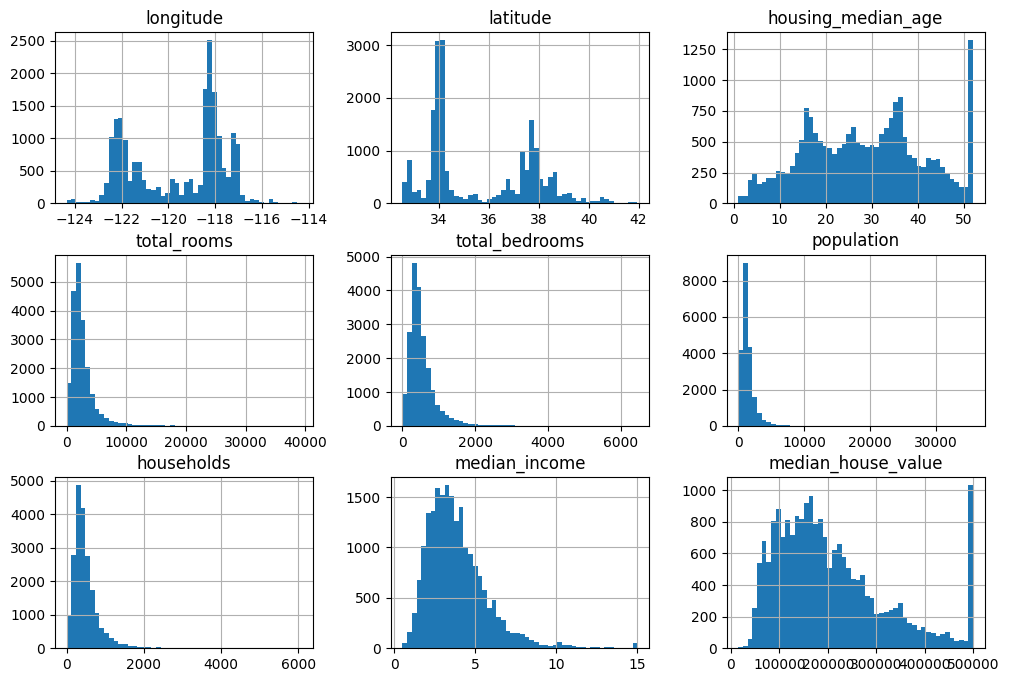

In [5]:
# Histogram of the DataFrame’s columns
housing.hist(bins=50, figsize=(12, 8))
plt.show()

Many of the histograms are skewed right.


## Test set and train set



To avoid **data snooping bias**, we create a train set and a test set.



### Stratification




Experts have pointed out that **median income** is a key factor in predicting housing prices. To ensure the test set represents different income levels, we need to create an income category since median income is a continuous variable.  


Looking at the histogram of the median income, most median income values are between 1.5 and 6 (about $15,000–$60,000), but some go higher. To avoid bias, ensure that:
1. You don’t have too many categories (strata).
2. Each category has enough data.


The code below uses `pd.cut()` to create five income categories:  
- **Category 1**: 0 to 1.5 (less than $15,000)  
- **Category 2**: 1.5 to 3, and so on.


In [6]:
# Create an additional column : income_category use to stratify the data
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

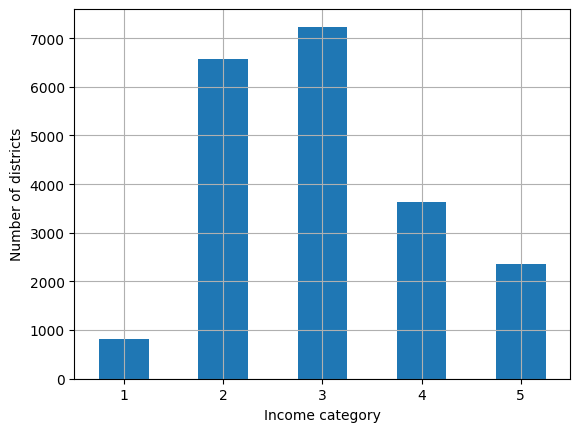

In [7]:
# Represent the income categories
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

### Train test split




We split the data in : <br>
- a train on which we will train our final model
- a test set we will use to evaluate the model (in the end)


In [8]:
# Create train set and test set (stratified based on median incom categories)
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)


We won't use the income_cat column agoin. Let's drop it from the data.


In [9]:
# Drop the income_category column from the strat_train_set and the strat_test_set
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Explore and visualizing the data to gain insights


In [10]:
# Create a copy of the stratified train set before exploring
housing = strat_train_set.copy()

### Visualizing Geographical data


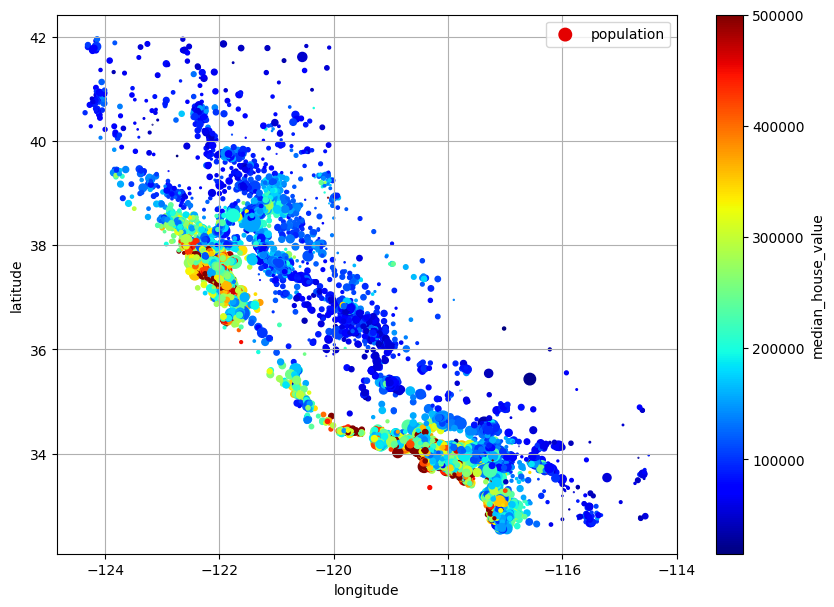

In [11]:
# Geographical scatter plot of the data
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

It seems that the most high median house values are higher in **large density population zones** and **near the ocean**.



### Correlations


In [12]:
# Compute standard correlation coeficient (Pearson)
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

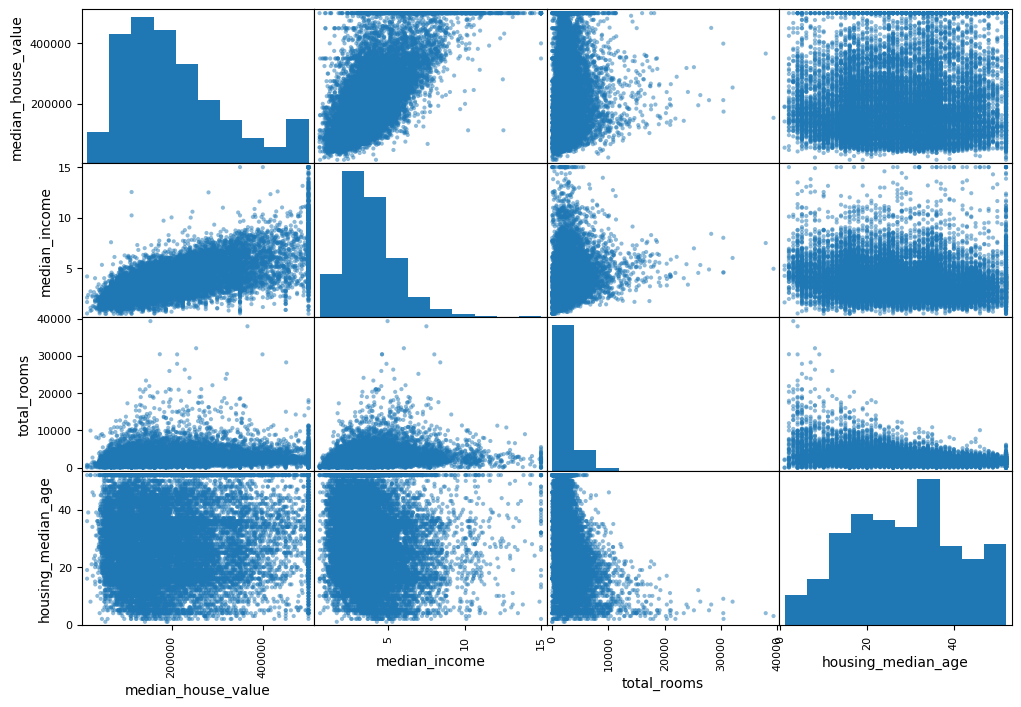

In [13]:
# Scatter matrix
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

### Experiment with attribute combinations


Before preparing the data for machine learning, it can help to create new attributes by combining existing ones. For example:  
- The **total number of rooms** isn’t useful on its own unless you compare it to the **number of households** (rooms per household).  
- The **total number of bedrooms** is more meaningful when compared to the **total rooms** (bedrooms per room).  
- **Population per household** is another useful attribute to explore.  

These combinations can provide better insights for our model.


In [14]:
# Attribute combinations
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [15]:
# Correlation check
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

- The new `bedrooms_ratio` attribute is more closely related to housing prices than the total rooms or bedrooms. 
- Houses with fewer bedrooms per room tend to be more expensive. 
- Similarly, `rooms_per_household` is more useful than the total number of rooms, as larger houses are typically more expensive.


# Prepare the data for Machine Learning Algorithms


We separate the features from the target.


In [16]:
# Separate featues from target
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Cleaning the data



### Processing duplicates


We check the number of duplicated rows.


In [17]:
# Check number of rows before removing duplicates
print(f"Number of rows : {len(housing)}")

# Compute the number of duplicated rows
print(f"Number of duplicated rows : {housing.duplicated().sum()}")

# Remove duplicates
# housing = housing.drop_duplicates() 


Number of rows : 16512
Number of duplicated rows : 0


### Processing missing data


We check the percentage of missing values in the data at hand.


In [18]:
def get_missing_data(data):       
    # Counting the percentage of NaN for each column
    missing_data = data.isnull().sum().sort_values(ascending=False)/len(data)*100 #NaN percentage for each column

    # missing_data
    missing_data = missing_data[missing_data > 0]

    #Missing data column names
    missing_cols = missing_data.index.values.tolist()

    #Show missing data in percent
    return missing_data

missing_data = get_missing_data(housing)
missing_data


total_bedrooms    1.017442
dtype: float64

One solution is to replace the missing values by a representative value of the corresponding feature.


In [19]:
# Insatantiate a simple imputer implementing a median strategy
imputer = SimpleImputer(strategy="median")

# Select only the numerical features
housing_num = housing.select_dtypes(include=[np.number])

display(housing_num.head())

# Fitting the simple imputer on the numerical features
imputer.fit(housing_num)

# Applying/transforming the numerical columns with the simple imputer 
X = imputer.transform(housing_num)

# Convert the numpy array to a pandas dataframe
housing_num_tr = pd.DataFrame(X, columns=housing_num.columns, index= housing_num.index)
display(housing_num_tr.head())


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


After imputation, let's check if we still have missing values in our data.


In [20]:
# Check for missing data
missing_data = get_missing_data(housing_num_tr)
missing_data

Series([], dtype: float64)

We don't have missing values now.


### Handling text and categorical attributes



To train the model, we need to tranform or encode categorical features to 'pseudo-numerical' features.


In [21]:
categorical_columns = ['ocean_proximity']

In [22]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [23]:
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7274
INLAND             5301
NEAR OCEAN         2089
NEAR BAY           1846
ISLAND                2
dtype: int64

We use a One Hot Encoder to generate binary columns based on the initial categorica feature.


In [24]:
# Instantiate the Onehotencoder
cat_encoder = OneHotEncoder(sparse_output=False)

# Fit and transform
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

# Create a pandas dataframe from numpy array
housing_cat_tr = pd.DataFrame(housing_cat_1hot, columns=cat_encoder.get_feature_names_out())
housing_cat_tr.head(2)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0


### Checking outliers

Let's check the outliers of the numerical columns.


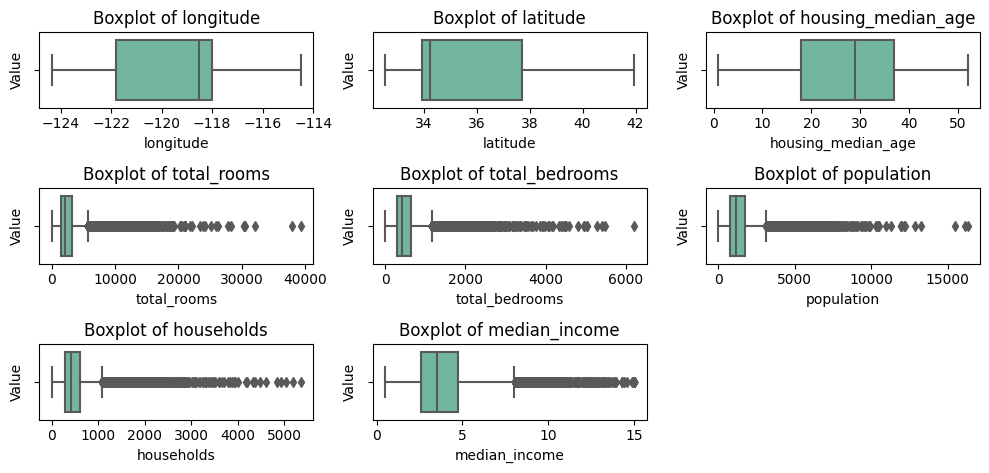

In [25]:
# Plot boxplots of each numerical column
plt.figure(figsize=(10, 20))

# for column in housing_num_tr.columns: 
for i, column in enumerate(housing_num_tr.columns.to_list(), 1):
    plt.subplot(13, 3, i)
    sns.boxplot(x=housing_num_tr[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

It would be useful to extract the features containing outliers automatically. It will be used for pipeline implementation.



Let's extract the features with outliers numerically !


In [26]:
# Identify the columns with outliers
numerical_columns_w_outliers = []
numerical_columns_no_outliers = []

for col in housing_num_tr.columns: 
    # Calculate IQR
    iqr_value = iqr(housing_num_tr[col])

    #Calculate 1st quartile
    q1 = np.percentile(housing_num_tr[col],25)

    #Calculate 3rd quartile
    q3 = np.percentile(housing_num_tr[col],75)

    #Calculate lower limit below which data point is considered an outlier
    outlier_lim_low = q1 - 1.5 * iqr_value

    #Calculate higher limit above which data point is considered an outlier
    outlier_lim_high = q3 + 1.5 * iqr_value
    
    #Calculate number of 'low' outliers
    outlier_condition_low = housing_num_tr[col] < outlier_lim_low
    number_outliers_low = len(housing_num_tr[outlier_condition_low][col])
    
    #Calculate number of 'high' outliers
    outlier_condition_high = housing_num_tr[col] > outlier_lim_high
    number_outliers_high = len(housing_num_tr[outlier_condition_high][col])
    
    #Calculate total number of outliers
    number_outliers_total = number_outliers_low + number_outliers_high
      
    #If any outliers in column, column is added to a list of columns with outliers
    if number_outliers_total > 0:
        numerical_columns_w_outliers.append(col)
    elif number_outliers_total == 0:
        numerical_columns_no_outliers.append(col)     

### Feature scaling and transformation


**WHY SCALING ??**

❗️ Features with large magnitudes can incorrectly outweigh features of small magnitudes <br>
⚡️ Scaling to smaller magnitudes improves computational efficiency <br>
🕵🏻‍♂️ Increases interpretability about the impact of each feature in a Machine Learning model <br>


#### Columns with outliers


<span style="font-family:Comic Sans MS; color:red">We consider using Robust scaling for columns WITH outliers !  </span>


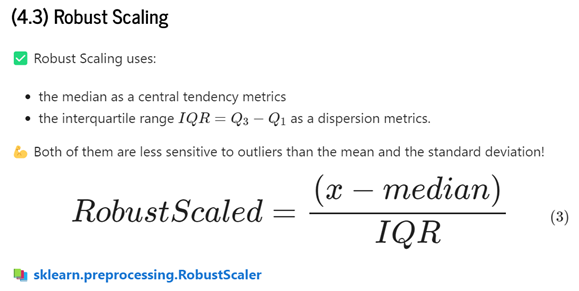


In [27]:
# Reminder of features with outliers
display(numerical_columns_w_outliers)

['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

Let's have a look of the statistics of numerical columns with outliers (**BEFORE SCALING**).



In [28]:
# Describe columns with outliers
housing_num_tr[numerical_columns_w_outliers].describe()

,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,2639.402798,537.881298,1425.513929,499.990189,3.870428
std,2185.287466,421.831667,1094.795467,382.865787,1.891936
min,2.000000,1.000000,3.000000,1.000000,0.499900
25%,1447.000000,297.000000,787.000000,279.000000,2.562500
50%,2125.000000,434.000000,1167.000000,408.000000,3.538500
75%,3154.000000,642.000000,1726.000000,603.000000,4.750000
max,39320.000000,6210.000000,16305.000000,5358.000000,15.000100


In [29]:
# Instantiate Robustscaler
robust_scaler = RobustScaler()

# Fit and transform
housing_num_tr[numerical_columns_w_outliers] = robust_scaler.fit_transform(housing_num_tr[numerical_columns_w_outliers])
housing_num_tr.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,0.700644,1.973913,0.435570,1.932099,-0.658194
14973,-118.38,34.14,40.0,-0.093732,-0.231884,-0.533546,-0.157407,1.165303
3785,-121.98,38.36,33.0,-0.610428,-0.628986,-0.644302,-0.632716,-0.505371


Now, let's check the statistics of the numerical columns with outliers (**AFTER SCALING**).



In [30]:
# Describe columns with outliers
housing_num_tr[numerical_columns_w_outliers].describe()

,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,0.301349,0.301105,0.275308,0.283920,0.151739
std,1.280192,1.222700,1.165916,1.181685,0.864885
min,-1.243702,-1.255072,-1.239617,-1.256173,-1.389074
25%,-0.397188,-0.397101,-0.404686,-0.398148,-0.446171
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.602812,0.602899,0.595314,0.601852,0.553829
max,21.789690,16.742029,16.121406,15.277778,5.239589


#### Columns without outliers


<span style="font-family:Comic Sans MS; color:red">We consider using MinMax scaling for columns WITHOUT outliers !  </span>


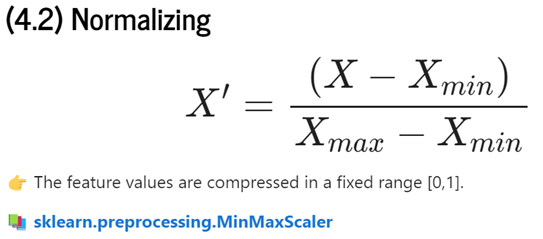
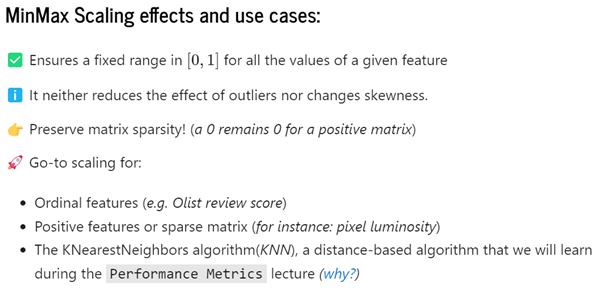


Let's have a look of the statistics of numerical columns without outliers (**BEFORE SCALING**).


In [31]:
# Describe columns with NO outliers
housing_num_tr[numerical_columns_no_outliers].describe()

,longitude,latitude,housing_median_age
count,16512.000000,16512.000000,16512.000000
mean,-119.573125,35.637746,28.577156
std,2.000624,2.133294,12.585738
min,-124.350000,32.550000,1.000000
25%,-121.800000,33.930000,18.000000
50%,-118.510000,34.260000,29.000000
75%,-118.010000,37.720000,37.000000
max,-114.490000,41.950000,52.000000


In [32]:
#Instanciate, fit, transform with minmax scaler
minmax_scaler = MinMaxScaler()
housing_num_tr[numerical_columns_no_outliers] = minmax_scaler.fit_transform(housing_num_tr[numerical_columns_no_outliers])

Now, let's check the statistics of the numerical columns without outliers (**AFTER SCALING**).


In [33]:
# Describe columns with NO outliers
housing_num_tr[numerical_columns_no_outliers].describe()

,longitude,latitude,housing_median_age
count,16512.000000,16512.000000,16512.000000
mean,0.484470,0.328484,0.540729
std,0.202903,0.226946,0.246779
min,0.000000,0.000000,0.000000
25%,0.258621,0.146809,0.333333
50%,0.592292,0.181915,0.549020
75%,0.643002,0.550000,0.705882
max,1.000000,1.000000,1.000000


### Create pipelines


In [34]:
# Reminder of the columns to deal with
print(numerical_columns_w_outliers)
print(numerical_columns_no_outliers)
print(categorical_columns)

['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
['longitude', 'latitude', 'housing_median_age']
['ocean_proximity']


In [35]:
# Create pipelines
num_transformer_w_outliers = make_pipeline(SimpleImputer(strategy="median"), RobustScaler())
num_transformer_no_outliers = make_pipeline(SimpleImputer(strategy="median"), MinMaxScaler())
cat_transformer = OneHotEncoder(sparse_output=False)

# 'Assemble' the pipelines
preprocessing = make_column_transformer(
                                        (num_transformer_w_outliers, numerical_columns_w_outliers),
                                        (num_transformer_no_outliers, numerical_columns_no_outliers),
                                        (cat_transformer, categorical_columns)
                                        )

preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['longitude', 'latitude',
                                  'housing_median_age']),
                                ('onehotencoder',
                                 OneHotEncoder(sparse_output=False),
                                 ['ocean_proximity'])])

# Select and train a model




In [36]:
# Separate featues from target
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Train and evaluate on the training set with linreg




In [37]:
# Train a LinearRegression model
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['ocean_proximity'])])),
                ('linearregression', LinearRegression())])

In [38]:
# Predictions 
housing_predictions = lin_reg.predict(housing)
print(housing_predictions[:5].round(-2))  # -2 = rounded to the nearest hundred

# reality
print(housing_labels.iloc[:5].values)

[270900. 334800. 119900. 109200. 305600.]
[458300. 483800. 101700.  96100. 361800.]


The predictions don't seem to be close to the housing labels (i.e reality).


In [39]:
# Evaluate
lin_rmse = mean_squared_error(housing_labels, housing_predictions,squared=False)
lin_rmse

68232.83515124217

Let's do a Cross Validation of the linear regression (preprocessing + linear regression model).


In [40]:
# Cross validation
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(lin_rmses).describe()

count       10.000000
mean     68315.632857
std       1024.244860
min      67251.778873
25%      67454.586853
50%      68046.527908
75%      68959.108436
max      69952.430271
dtype: float64

Let's choose this model as a baseline.


Are other models better ?


## Train and evaluate on the training set with DecisionTreeRegressor




In [41]:
# Train a DecisionTreeRegressor model
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['ocean_proximity'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [42]:
# Predictions 
housing_predictions = tree_reg.predict(housing)
print(housing_predictions[:5].round(-2))  # -2 = rounded to the nearest hundred

# reality
print(housing_labels.iloc[:5].values)

[458300. 483800. 101700.  96100. 361800.]
[458300. 483800. 101700.  96100. 361800.]


In [43]:
# Evaluate
tree_rmse = mean_squared_error(housing_labels, housing_predictions,squared=False)
tree_rmse

0.0

Let's do a Cross Validation of the linear regression (preprocessing + Decision Tree Regressor model).



In [44]:
# Cross validation
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(tree_rmses).describe()

count       10.000000
mean     68698.719504
std       1233.004353
min      67440.626793
25%      67806.994495
50%      68166.420661
75%      69749.804524
max      70835.522965
dtype: float64

**Linear regression model** seems a bit better than the **Decision tree regressor**, looking at the standard deviations of both models.




## Train and evaluate on the training set with RandomForestRegressor



In [45]:
# Train a RandomForestRegressor model
forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))

forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

display(pd.Series(forest_rmses).describe())


count       10.000000
mean     48909.955353
std        732.910178
min      47512.666892
25%      48480.090271
50%      48921.770992
75%      49365.209889
max      50056.069286
dtype: float64

**RandomForestRegressor** seems better than **Linear regression model**, looking at the standard deviations of both models.




Let's use the **Random Forest Regressor** for our task !



# Fine tune the model



Let's fine tuned our model (**Random Forest Regressor**).



## Grid Search



In [46]:
# Reminder of the pipeline structure
forest_reg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['ocean_proximity'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

What are the available hyper parameters of the regressor ?


In [47]:
# Get the pipeline parmeters
forest_reg.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'randomforestregressor', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__pipeline-1', 'columntransformer__pipeline-2', 'columntransformer__onehotencoder', 'columntransformer__pipeline-1__memory', 'columntransformer__pipeline-1__steps', 'columntransformer__pipeline-1__verbose', 'columntransformer__pipeline-1__simpleimputer', 'columntransformer__pipeline-1__robustscaler', 'columntransformer__pipeline-1__simpleimputer__add_indicator', 'columntransformer__pipeline-1__simpleimputer__copy', 'columntransformer__pipeline-1__simpleimputer__fill_value', 'columntransformer__pipeline-1__simpleimputer__keep_empty_features', 'columntransformer__pipeline-1__simpleimputer__missing_values', 'columntransformer__pipeline

In [48]:
%%time
# Create grid
param_grid = [
                {'randomforestregressor__n_estimators' : [100, 200],
                 'randomforestregressor__max_depth' : [10, 20]}
            ]

# Perform Grid Search
grid_search = GridSearchCV(forest_reg, param_grid, cv=3,scoring='neg_root_mean_squared_error')

# Fit data to Grid Search
grid_search.fit(housing, housing_labels)

CPU times: user 1min 55s, sys: 611 ms, total: 1min 55s
Wall time: 1min 55s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['total_rooms',
                                                                          'total_bedrooms',
                                                                          'population',
                                                                          'households',
                                                                          'median_income']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(s...
                                                                                          MinMaxScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
                                                                          'housing_median_age']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         ['ocean_proximity'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'randomforestregressor__max_depth': [10, 20],
                          'randomforestregressor__n_estimators': [100, 200]}],
             scoring='neg_root_mean_squared_error')

The best hyperparameter combination found:


In [49]:
# Get the best params found
grid_search.best_params_

{'randomforestregressor__max_depth': 20,
 'randomforestregressor__n_estimators': 200}

In [50]:
# Get the best estimator found
grid_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['ocean_proximity'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=20, n_estimators=200,
                                       random_state=42))])

👎 Limitations of Grid Search:<br>
•	Computationally costly <br>
•	The optimal hyperparameter value can be missed <br>
•	Can overfit hyperparameters to the training set if too many combinations are tried out for too small a dataset


## Random search



In [65]:
%%time
# Create grid
param_distribs = [
                {'randomforestregressor__n_estimators' : [np.random.randint(low = 100, high = 200)],
                 'randomforestregressor__max_depth' : [np.random.randint(low = 10, high = 20)]}
            ]

# Perform Grid Search
rnd_search = GridSearchCV(forest_reg, param_distribs, cv=3,scoring='neg_root_mean_squared_error')
rnd_search.fit(housing, housing_labels)


CPU times: user 31.2 s, sys: 29.7 ms, total: 31.2 s
Wall time: 31.2 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['total_rooms',
                                                                          'total_bedrooms',
                                                                          'population',
                                                                          'households',
                                                                          'median_income']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(s...
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
                                                                          'housing_median_age']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         ['ocean_proximity'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'randomforestregressor__max_depth': [11],
                          'randomforestregressor__n_estimators': [168]}],
             scoring='neg_root_mean_squared_error')

The best hyperparameter combination found:

In [66]:
# Get the best params found
rnd_search.best_params_

{'randomforestregressor__max_depth': 11,
 'randomforestregressor__n_estimators': 168}

In [67]:
# Get the best estimator found
rnd_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['ocean_proximity'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=11, n_estimators=168,
                                       random_state=42))])

# Analyse the best models and their errors


Let's check the relative importance of each feature for making accurate predictions.


In [70]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["randomforestregressor"].feature_importances_
feature_importances.round(2)


array([0.01, 0.01, 0.02, 0.01, 0.53, 0.1 , 0.1 , 0.04, 0.  , 0.16, 0.  ,
       0.  , 0.01])

Let's sort the importance scores in descending order and displau them next to their corresponding attribute names.


In [74]:
sorted(zip(feature_importances,
           final_model["columntransformer"].get_feature_names_out()),
           reverse=True)

[(0.5301107995363001, 'pipeline-1__median_income'),
 (0.1618274642666515, 'onehotencoder__ocean_proximity_INLAND'),
 (0.10262222944611538, 'pipeline-2__longitude'),
 (0.09682957400736679, 'pipeline-2__latitude'),
 (0.04324650648480269, 'pipeline-2__housing_median_age'),
 (0.01723065121645916, 'pipeline-1__population'),
 (0.014609761176993016, 'pipeline-1__total_rooms'),
 (0.012582659434779968, 'pipeline-1__total_bedrooms'),
 (0.010240649485275057, 'pipeline-1__households'),
 (0.006477544331095999, 'onehotencoder__ocean_proximity_NEAR OCEAN'),
 (0.003229470054508415, 'onehotencoder__ocean_proximity_<1H OCEAN'),
 (0.0005738625228081909, 'onehotencoder__ocean_proximity_NEAR BAY'),
 (0.00041882803684354313, 'onehotencoder__ocean_proximity_ISLAND')]

With this information, we may want to try dropping some of the less useful features.


# Evaluate the system on the Test set


In [75]:
# Separate featues from target
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [76]:
# Make the predictions
final_predictions = final_model.predict(X_test)

In [77]:
# Calculation of metric
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

52519.035644346324


In [79]:
# Compute 95% confidence interval
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))


array([50086.49811859, 54843.78648708])

# Save the model


In [83]:
# Saving the best model
joblib.dump(final_model, "../data/processed_data/my_california_housing_model.pkl")

['../data/processed_data/my_california_housing_model.pkl']

# Load the model


In [84]:
# Reloading the saved model
final_model_reloaded = joblib.load("../data/processed_data/my_california_housing_model.pkl")

In [86]:
# Make new predictions
new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)
predictions

array([357616.35255228, 445195.68600856, 102258.71771732, 105490.53328072,
       321908.30261826])